In [15]:
import datetime
import random
import numpy as np
import pandas as pd

import glob
import os
import matplotlib.pyplot as plt
from sklearn.utils.random import sample_without_replacement
import geopandas as gpd
import os
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry import Polygon
import alphashape
import osmnx as ox
from shapely.wkt import loads

data_path = '../../data/' 
paris_districts = gpd.read_file(data_path + 'districts_paris.geojson')
df_car_detectors = gpd.read_file(data_path + 'all_car_detectors.geojson')
matched_detectors_2013 = pd.read_csv('../network_matching/output/detectors_matched_2_osm_01_2013.csv', sep=";")
matched_detectors_2023 = pd.read_csv('../network_matching/output/detectors_matched_2_osm_01_2024.csv', sep=";")
# best_matches_2013 = pd.read_csv('../network_matching/output/best_matches_2013.csv', sep=";")
# best_matches_2022 = pd.read_csv('../network_matching/output/best_matches_2022.csv', sep=";")
qgis_road_network = gpd.read_file(data_path + 'network/QGIS_Project/referentiel-comptages-edit.shp')
alpha_shape = alphashape.alphashape(qgis_road_network, 435)
coordinates = list(alpha_shape.exterior[0].coords)
polygon = Polygon(coordinates)

resultpath = 'results/'

def merge_districts(districts_to_merge:list):
    districts_to_merge = paris_districts[paris_districts['c_ar'].isin(districts_to_merge)]
    merged_districts = districts_to_merge.unary_union
    merged = gpd.GeoDataFrame(geometry=[merged_districts], crs=paris_districts.crs)
    return merged

def read_detector_data():
    ldd_2010_2012 = pd.read_csv(data_path + '/traffic_data/traffic_data_2010_2012.csv')
    # ldd_2013_2020 = pd.read_csv(data_path + 'traffic_data.csv')
    ldd_2021_2022 = pd.read_csv(data_path + '/traffic_data/traffic_data_2021_2022.csv')
    ldd = pd.concat([ldd_2010_2012, ldd_2021_2022])
    ldd['t_1h'] = pd.to_datetime(ldd['t_1h'])
    ldd_2010 = ldd[ldd['t_1h'].dt.year == 2010]
    ldd_2022 = ldd[ldd['t_1h'].dt.year == 2022]
    return ldd_2010, ldd_2022

def read_detector_data_2023():
    ldd_2023 = pd.read_csv(data_path + '/traffic_data/traffic_data_2023.csv')
    ldd_2023['t_1h'] = pd.to_datetime(ldd_2023['t_1h'])
    return ldd_2023

class ResampledMFD():
    def __init__(self, ldd, p_sample: float, n_combinations: int):
        self.ldd = ldd
        self.p_sample = p_sample
        self.n_combinations = n_combinations

    def compute_resampled_mfd(self):
        self.resampled_mfd = ResampledMFD.resample_mfd(
            self.ldd, self.p_sample, self.n_combinations)
        resampled_mfd_envelope, capacity, critical_occupancy = ResampledMFD.get_resampled_mfd_envelope(
            self.resampled_mfd)
        self.resampled_mfd_envelope = resampled_mfd_envelope
        self.capacity = capacity
        self.critical_occupancy = critical_occupancy
        return

    def print_resampled_mfd(self):
        print(self.capacity, self.critical_occupancy)

    def resample_mfd(ldd, p_sample, n_combinations):
        n_population = ldd.iu_ac.nunique()
        n_samples = int(n_population * p_sample)

        population = ldd.iu_ac.unique().tolist()
        population_subsets = []
        seen_subsets = set()

        while len(population_subsets) < n_combinations:
            subsets_indices = tuple(
                sorted(sample_without_replacement(n_population, n_samples)))
            if subsets_indices not in seen_subsets:
                subset = [population[n] for n in subsets_indices]
                population_subsets.append(subset)
                seen_subsets.add(subsets_indices)
            else:
                continue

        subsets_mfds = []
        for idx, subset in enumerate(population_subsets):
            # print(idx/len(population_subsets))
            subset_ldd = ldd.loc[ldd.iu_ac.isin(subset)]

            mfd = []
            for tsp, temp in subset_ldd.groupby('t_1h'):
                time = (tsp - datetime.datetime.combine(tsp.date(),
                        datetime.time.min)).total_seconds()
                flow = temp.q_per_lane_km.mean()
                occupancy = temp.k_per_lane_km.mean()
                # TODO Hier normalisieren mit den Anzahl an Lanes und der Länge der Straße.
                mfd.append((tsp, time, flow, occupancy))
            mfd = pd.DataFrame(
                mfd, columns=['tsp', 'time', 'flow', 'occupancy'])
            subsets_mfds.append(mfd)

        resampled_mfd = pd.concat(subsets_mfds)
        return resampled_mfd


    def get_resampled_mfd_envelope(resampled_mfd):
        # choose the number of bins that best fits occupancy values
        resampled_mfd['occupancy_bin'] = pd.cut(resampled_mfd['occupancy'],
                                                bins=int(resampled_mfd['occupancy'].max()))
        # taking the median of top M flow values per occupancy bin
        resampled_mfd_envelope = []
        for bin, temp in resampled_mfd.groupby('occupancy_bin', observed=True):
            upper_flow = temp.nlargest(50, 'flow', 'all').flow.median()
            occupancy = bin.mid
            resampled_mfd_envelope.append((upper_flow, occupancy))
        resampled_mfd_envelope = pd.DataFrame(
            resampled_mfd_envelope, columns=['flow', 'occupancy'])

        # calculate the 95th/ 97.5th percentile of flow as the capacity
        capacity = np.percentile(
            resampled_mfd_envelope.flow, 97.5, method='nearest')

        rounded_capacity = round(capacity, 2)

        matching_rows = resampled_mfd_envelope.loc[round(
            resampled_mfd_envelope.flow, 2) == rounded_capacity]
        if not matching_rows.empty:
            critical_occupancy = matching_rows['occupancy'].iloc[0]
        else:
            # Handle the case where no rows match the condition
            # You might want to set a default value or raise an exception
            critical_occupancy = None  # or any other suitable value

        return resampled_mfd_envelope, capacity, critical_occupancy


def get_ldd_for_district(district_list: list, gdf_ldd: gpd.GeoDataFrame):
    districts = merge_districts(district_list)
    ldd_within_districts = gpd.sjoin(
        gdf_ldd, districts, how="inner", op="within")
    ldd_within_districts.drop(columns=['index_right'], inplace=True)
    ldd_within_districts = ldd_within_districts.groupby(["iu_ac", "day"]).filter(
        lambda x: len(x) == 18 and x["q"].notnull().all() and x["k"].notnull().all())
    ldd_within_districts.reset_index(drop=True, inplace=True)
    return ldd_within_districts


def filter_outliers(df, column_name):
    # Calculate the first and third quartiles
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 8 * IQR
    upper_bound = Q3 + 8 * IQR

    # Filter the data
    filtered_df = df[(df[column_name] >= lower_bound) &
                     (df[column_name] <= upper_bound)]

    return filtered_df

def is_parallel(linestring1, linestring2):
    x1, y1 = linestring1.xy
    x2, y2 = linestring2.xy
    if abs(x2[-1] - x2[0]) < 1e-6 or abs(x1[-1] - x1[0]) < 1e-6:
        return True
    slope1 = (y1[-1] - y1[0]) / (x1[-1] - x1[0])
    slope2 = (y2[-1] - y2[0]) / (x2[-1] - x2[0])
    return abs(slope1 - slope2) < 0.2

def get_road_network_graph(polygon):
    ox.settings.log_console = True
    G_road_network = ox.graph_from_polygon(
        polygon, simplify=True, network_type="drive")
    nodes, edges = momepy.nx_to_gdf(G_road_network, points=True, lines=True)
    edges['index'] = range(1, len(edges) + 1)
    return nodes, edges

def process_car_detectors(polygon):
    df_car_detectors_without_multiples = df_car_detectors.drop_duplicates(
        subset='iu_ac', keep='first')
    boundary_gdf = gpd.GeoDataFrame(
        geometry=[polygon], crs=df_car_detectors_without_multiples.crs)
    car_detectors_within_boundary = gpd.sjoin(
        df_car_detectors_without_multiples, boundary_gdf, op='within')
    return car_detectors_within_boundary

def get_merged_geodataframe(matched_detectors, ldd):
    matched_detectors_without_dupl = matched_detectors.drop_duplicates(
        subset='iu_ac', keep='first')
    merged_ldd = pd.merge(ldd, matched_detectors_without_dupl[[
                      'iu_ac', 'geometry_detector', 'highway', 'oneway', 'length_mapped_osm_street','score','length_detector_street','lanes_mapped']], on='iu_ac', how='inner')
    merged_ldd['geometry_detector'] = merged_ldd['geometry_detector'].apply(loads)
    return gpd.GeoDataFrame(merged_ldd, geometry='geometry_detector')

def plot_mfds_for_district(district: str, mfd_2010: ResampledMFD, mfd_2022: ResampledMFD, p_sample, n_combinations):
    fig, ax = plt.subplots()
    # plt.gcf().set_size_inches(4, 3) 
    plt.scatter(mfd_2010.resampled_mfd['occupancy'],
                mfd_2010.resampled_mfd['flow'], s=0.5, color='grey', label='resampled MFD 2010')
    plt.hlines(y=mfd_2010.capacity, xmin=0, xmax=mfd_2010.critical_occupancy, color='orange',
               linestyle='-')
    plt.vlines(x=mfd_2010.critical_occupancy, ymin=0, ymax=mfd_2010.capacity, color='orange',
               linestyle='-')
    plt.scatter(mfd_2010.resampled_mfd_envelope['occupancy'], mfd_2010.resampled_mfd_envelope['flow'],
                marker='s', s=10, color='orange', label='MFD envelope 2010')

    plt.scatter(mfd_2022.resampled_mfd['occupancy'],
                mfd_2022.resampled_mfd['flow'], s=0.5, color='darkgrey', label='resampled MFD 2023')
    plt.hlines(y=mfd_2022.capacity, xmin=0, xmax=mfd_2022.critical_occupancy, color='blue',
               linestyle='-')
    plt.vlines(x=mfd_2022.critical_occupancy, ymin=0, ymax=mfd_2022.capacity, color='blue',
               linestyle='-')
    plt.scatter(mfd_2022.resampled_mfd_envelope['occupancy'], mfd_2022.resampled_mfd_envelope['flow'],
                marker='s', s=10, color='blue', label='MFD envelope 2023')

    # if district == str([1, 2, 3, 4]):
    #     plt.xlim(0, 90)
    #     plt.ylim(0, 7500)
    # elif district == str([5, 6, 7]):
    #     plt.xlim(0, 100)
    #     plt.ylim(0, 7000)
    plt.xlabel('Density [veh/lane-km]')
    plt.ylabel('Flow [veh/lane-km/h]')
    plt.title('Resampled MFD (lane km) for districts ' + district+ "_" + str(p_sample) + "_" + str(n_combinations) + ' in 2010 and 2023')
   
    plt.legend()
    plt.savefig(resultpath + 'resampled_mfd_per_lane_km_district_' + district + "_" +
                str(p_sample) + "_" + str(n_combinations) + ".pdf", dpi=10, bbox_inches='tight')
    plt.show()

In [9]:
matched_detectors_2013

,iu_ac,geometry_detector,osm_id,lanes,highway,oneway,length_mapped_osm_street,score,length_detector_street,lanes_mapped
0,1,LINESTRING (2.3334197551070193 48.860029766743...,14806,NaN,primary,True,204.263,0.003808,127.877045,3.07947
1,10,LINESTRING (2.3494702231163145 48.856482615219...,1169,NaN,primary,True,143.586,0.001123,94.716807,3.07947
2,100,LINESTRING (2.349936838735553 48.8488813421484...,3719,NaN,secondary,True,116.979,0.002275,128.196599,2.43750
3,1005,LINESTRING (2.3324867135109617 48.827833881417...,2916,NaN,secondary,False,147.162,0.002347,418.329528,2.43750
4,1006,LINESTRING (2.3267874979342844 48.827874559746...,3017,NaN,secondary,False,147.162,0.003584,418.199171,2.43750
...,...,...,...,...,...,...,...,...,...,...
2714,986,LINESTRING (2.2710943347487587 48.840205318330...,10322,NaN,primary,True,37.536,0.005929,66.719287,3.07947
2715,99,LINESTRING (2.350508817916281 48.8481170174724...,978,NaN,secondary,True,53.408,0.003537,94.764298,2.43750
2716,994,LINESTRING (2.399342526736385 48.8307872040525...,13938,NaN,primary,False,145.294,0.001556,142.898625,3.07947
2717,996,LINESTRING (2.40170496556511 48.82925027049043...,14897,NaN,primary,False,173.843,0.004328,75.908464,3.07947


In [10]:
car_detectors = process_car_detectors(polygon)

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Distinguished in primary and others

In [11]:
ldd_2010, ldd_2022 = read_detector_data()
ldd_2023 = read_detector_data_2023()

In [12]:
ldd_2010

,iu_ac,t_1h,q,k,hour,day
0,799,2010-01-01 05:00:00,NaN,1.0,5,2010-01-01
1,799,2010-01-01 06:00:00,NaN,1.0,6,2010-01-01
2,799,2010-01-01 07:00:00,NaN,0.0,7,2010-01-01
3,799,2010-01-01 08:00:00,NaN,0.0,8,2010-01-01
4,799,2010-01-01 09:00:00,NaN,0.0,9,2010-01-01
...,...,...,...,...,...,...
15346417,5047,2010-12-31 18:00:00,NaN,NaN,18,2010-12-31
15346418,5047,2010-12-31 19:00:00,NaN,NaN,19,2010-12-31
15346419,5047,2010-12-31 20:00:00,NaN,NaN,20,2010-12-31
15346420,5047,2010-12-31 21:00:00,NaN,NaN,21,2010-12-31


In [13]:
matched_detectors_2013

,iu_ac,geometry_detector,osm_id,lanes,highway,oneway,length_mapped_osm_street,score,length_detector_street,lanes_mapped
0,1,LINESTRING (2.3334197551070193 48.860029766743...,14806,NaN,primary,True,204.263,0.003808,127.877045,3.07947
1,10,LINESTRING (2.3494702231163145 48.856482615219...,1169,NaN,primary,True,143.586,0.001123,94.716807,3.07947
2,100,LINESTRING (2.349936838735553 48.8488813421484...,3719,NaN,secondary,True,116.979,0.002275,128.196599,2.43750
3,1005,LINESTRING (2.3324867135109617 48.827833881417...,2916,NaN,secondary,False,147.162,0.002347,418.329528,2.43750
4,1006,LINESTRING (2.3267874979342844 48.827874559746...,3017,NaN,secondary,False,147.162,0.003584,418.199171,2.43750
...,...,...,...,...,...,...,...,...,...,...
2714,986,LINESTRING (2.2710943347487587 48.840205318330...,10322,NaN,primary,True,37.536,0.005929,66.719287,3.07947
2715,99,LINESTRING (2.350508817916281 48.8481170174724...,978,NaN,secondary,True,53.408,0.003537,94.764298,2.43750
2716,994,LINESTRING (2.399342526736385 48.8307872040525...,13938,NaN,primary,False,145.294,0.001556,142.898625,3.07947
2717,996,LINESTRING (2.40170496556511 48.82925027049043...,14897,NaN,primary,False,173.843,0.004328,75.908464,3.07947


In [16]:
gdf_ldd_2010 = get_merged_geodataframe(matched_detectors_2013, ldd_2010)
gdf_ldd_2023 = get_merged_geodataframe(matched_detectors_2023, ldd_2023)

   iu_ac                                  geometry_detector  osm_id  lanes  \
0      1  LINESTRING (2.3334197551070193 48.860029766743...   14806    NaN   
1     10  LINESTRING (2.3494702231163145 48.856482615219...    1169    NaN   
2    100  LINESTRING (2.349936838735553 48.8488813421484...    3719    NaN   
3   1005  LINESTRING (2.3324867135109617 48.827833881417...    2916    NaN   
4   1006  LINESTRING (2.3267874979342844 48.827874559746...    3017    NaN   

     highway  oneway  length_mapped_osm_street     score  \
0    primary    True                   204.263  0.003808   
1    primary    True                   143.586  0.001123   
2  secondary    True                   116.979  0.002275   
3  secondary   False                   147.162  0.002347   
4  secondary   False                   147.162  0.003584   

   length_detector_street  lanes_mapped  
0              127.877045       3.07947  
1               94.716807       3.07947  
2              128.196599       2.43750  
3 

In gdf_merged_ldd sind weniger Einträge als in ldd. Es ist also anzunehmen, dass manche Detektoren, für die zwar gemessen wurde, nicht in dem eigentlichen Ding drin sind. 

## Create MFDs

Zuerst erstellen wir die resampled MFDs. Zunächst für ldd_district_1_4_2010.

0 [1, 2, 3, 4]


/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_72340/1631189798.py:147: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  ldd_within_districts = gpd.sjoin(
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/

6639.5394014423255 61.7915
4344.272664738947 70.601


/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_72340/1631189798.py:241: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(resultpath + 'resampled_mfd_per_lane_km_district_' + district + "_" +
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_72340/1631189798.py:241: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(resultpath + 'resampled_mfd_per_lane_km_district_' + district + "_" +
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


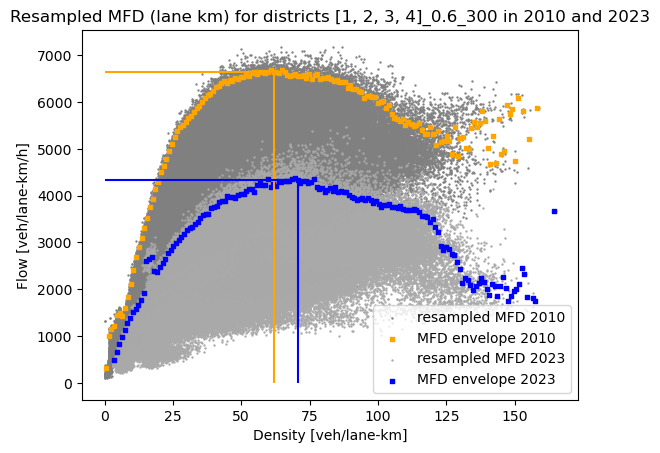

1 [5, 6, 7]


/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_72340/1631189798.py:147: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  ldd_within_districts = gpd.sjoin(
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/

5870.926745601293 47.0315
5678.105485409851 67.31649999999999


/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_72340/1631189798.py:241: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(resultpath + 'resampled_mfd_per_lane_km_district_' + district + "_" +
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_72340/1631189798.py:241: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(resultpath + 'resampled_mfd_per_lane_km_district_' + district + "_" +
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


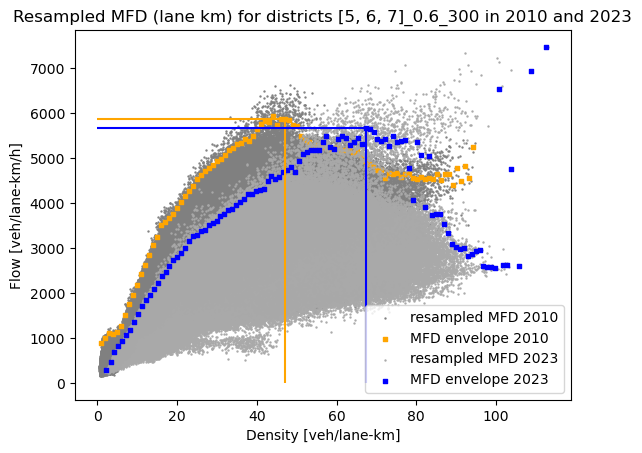

In [36]:
import pickle
# districts_to_test = [[1, 2, 3, 4], [5, 6, 7], [1, 2, 3], [5, 6], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]
districts_to_test = [[1, 2, 3, 4], [5, 6, 7]]

for idx, district in enumerate(districts_to_test):
    print(idx, district)
    ldd_district_2010 = get_ldd_for_district(district, gdf_ldd_2010)
    ldd_district_2023 = get_ldd_for_district(district, gdf_ldd_2023)

    # Map values to respective lane km
    ldd_district_2010['q_per_lane_km'] = ldd_district_2010['q'] * 1000 / (ldd_district_2010['length_detector_street'] * ldd_district_2010['lanes_mapped'])
    ldd_district_2010['k_per_lane_km'] = ldd_district_2010['k'] * 1000 / (ldd_district_2010['length_detector_street'] * ldd_district_2010['lanes_mapped'])

    ldd_district_2023['q_per_lane_km'] = ldd_district_2023['q'] * 1000 / (ldd_district_2023['length_detector_street'] * ldd_district_2023['lanes_mapped'])
    ldd_district_2023['k_per_lane_km'] = ldd_district_2023['k'] * 1000 / (ldd_district_2023['length_detector_street'] * ldd_district_2023['lanes_mapped'])
    ldd_district_2023['t_1h'] = ldd_district_2023['t_1h'].dt.tz_localize(None)
    
    # # Filter for outliers
    # if district == [1, 2, 3, 4]:
    #     ldd_district_2010 = ldd_district_2010[ldd_district_2010['k_per_lane_km'] < 180]
    #     ldd_district_2022 = ldd_district_2023[ldd_district_2023['k_per_lane_km'] < 180]
    # elif district == [5, 6, 7]:
    #     ldd_district_2010 = ldd_district_2010[ldd_district_2010['k_per_lane_km'] < 100]
    #     ldd_district_2022 = ldd_district_2022[ldd_district_2022['k_per_lane_km'] < 100]
    # else:
    #     print("NOT OK")

    resampled_district_2010 = ResampledMFD(ldd_district_2010, 0.6, 300)
    resampled_district_2010.compute_resampled_mfd()
    resampled_district_2010.print_resampled_mfd()

    resampled_district_2023 = ResampledMFD(ldd_district_2023, 0.6, 300)
    resampled_district_2023.compute_resampled_mfd()
    resampled_district_2023.print_resampled_mfd()
    
    # resampled_mfd_object is your ResampledMFD object
    with open('resampled_mfd_' + str(district) + '_2010.pkl', 'wb') as f:
        pickle.dump(resampled_district_2010, f)

    with open('resampled_mfd_' + str(district) + '_2023.pkl', 'wb') as f:
        pickle.dump(resampled_district_2023, f)
    # plot_mfds_for_district(str(district), resampled_district_2010,
    #                        resampled_district_2023, 0.6, 300)

In [39]:
import pickle

with open('output/resampled_mfd_' + str(district) + '_2010.pkl', 'wb') as f:
        pickle.dump(resampled_district_2010, f)

with open('output/resampled_mfd_' + str(district) + '_2023.pkl', 'wb') as f:
    pickle.dump(resampled_district_2023, f)